## クラスタリング(HDBSCAN)にて学習済みモデルの特徴量を解析

### 対象

swin transformer

In [1]:
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from joblib import load, dump
from sklearn.cluster import HDBSCAN
from sklearn.decomposition import PCA
from pptx import Presentation
from pptx.util import Cm
from tqdm import tqdm

from src.data_handler import load_trainable_df
from src.const import OUTPUT_ROOT
from src.pptx_utils import (
    add_slide,
    add_picture,
    add_text,
    SLIDE_HEIGHT,
    SLIDE_WIDTH
)

/opt/conda/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

In [2]:
OOF_FEATURES_PICKLE_PATH = '/work/output/train_arcface/outputs/arcface_with_swinv2_small/predictions/oof_embeddings.pkl'
TEST_FEATURES_PICKLE_PATH = '/work/output/train_arcface/outputs/arcface_with_swinv2_small/predictions/test_embeddings.pkl'
CITE_FEATURES_PICKLE_PATH = '/work/output/train_arcface/outputs/arcface_with_swinv2_small/predictions/cite_embeddings.pkl'

DST_DIR = OUTPUT_ROOT / 'ana_with_clustering'
DST_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
(train_df, test_df, cite_df, sample_submission_df) = load_trainable_df()
train_df.set_index('gid', inplace=True)
train_df.head()

,filename,brand_id,meigara,brand_id_label,meigara_label,filepath
gid,,,,,,
200000001,200000001.jpg,3372,五橋,2211,445,/work/data/query_images/200000001.jpg
200000002,200000002.jpg,3751,庭のうぐいす,2454,1122,/work/data/query_images/200000002.jpg
200000003,200000003.jpg,2856,笑四季,1864,1819,/work/data/query_images/200000003.jpg
200000004,200000004.jpg,1527,鍋島,1005,2263,/work/data/query_images/200000004.jpg
200000005,200000005.jpg,2676,仙禽,1739,478,/work/data/query_images/200000005.jpg


## 特徴量のロード

In [7]:
# ロード
oof_gids_and_features = load(OOF_FEATURES_PICKLE_PATH)
oof_gids = np.array(oof_gids_and_features['gid'])
oof_features = oof_gids_and_features['embeddings']

## PCAで次元圧縮

In [6]:
pca = PCA(n_components=None, random_state=0)
oof_compressed_features = pca.fit_transform(oof_features)

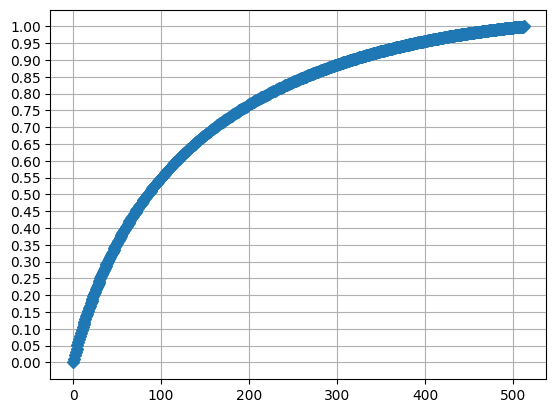

In [7]:
# 累積寄与率を図示する
cum_con_ratio = np.hstack([0, pca.explained_variance_ratio_]).cumsum()
plt.plot(cum_con_ratio, 'D-')
plt.yticks(np.arange(0,1.05,0.05))
plt.grid()
plt.show()

## HDBSCAN実行

In [5]:
oof_hdb = HDBSCAN(n_jobs=-1)
oof_hdb.fit(oof_features)
clusters = oof_hdb.labels_

In [20]:
dump(oof_hdb, DST_DIR / 'hdb.pkl')

['/work/output/ana_with_clustering/clusters.pkl']

In [6]:
oof_hdb = load(DST_DIR / 'hdb.pkl')

In [7]:
dist_left_cm = Cm(2)
dist_top_cm = Cm(0.5)
pic_height_cm = Cm(4.46)
initial_pic_left = Cm(1.63)
initial_pic_top = Cm(2.32)


prs = Presentation()
slide_layout = prs.slide_layouts[6]

for n_page, label in tqdm(enumerate(np.unique(hdb.labels_))):
    # スライドの追加
    slide = prs.slides.add_slide(slide_layout)

    count_i = 0
    count_j = 0
    add_text(slide, f'label: {label}')
    
    target_gids = oof_gids[oof_hdb.labels_ == label]
    imgs = train_df.loc[target_gids][:12]['filepath'].to_list()
    
    for i in imgs:
        # 1列目への貼り付け作業
        # 画像の挿入
        pic = slide.shapes.add_picture(i, 0, 0, width=None, height=pic_height_cm)
        # 画像を移動
        pic.left = initial_pic_left + count_i * (dist_left_cm + pic.width)
        pic.top  = initial_pic_top + count_j * (dist_top_cm + pic.height)
        count_i += 1
        # 2列目以降に作業を移行するためにカウントを調整
        if count_i == 4:
            count_i = 0
            count_j += 1
    if (n_page + 1) % 100 == 0:
        #### 保存 #####
        prs.save(str(DST_DIR / f'cluster_imgs_{n_page + 1}.pptx'))
        prs = Presentation()
        slide_layout = prs.slide_layouts[6]

3136it [04:48, 10.87it/s]


In [8]:
oof_cluster_df = pd.read_csv('/work/output/ana_with_clustering/clusters_with_gid.csv')
train_df_with_cluster = train_df.merge(oof_cluster_df, on='gid')
train_df_with_cluster

,gid,filename,brand_id,meigara,brand_id_label,meigara_label,filepath,label
0,200000001,200000001.jpg,3372,五橋,2211,445,/work/data/query_images/200000001.jpg,-1
1,200000002,200000002.jpg,3751,庭のうぐいす,2454,1122,/work/data/query_images/200000002.jpg,375
2,200000003,200000003.jpg,2856,笑四季,1864,1819,/work/data/query_images/200000003.jpg,-1
3,200000004,200000004.jpg,1527,鍋島,1005,2263,/work/data/query_images/200000004.jpg,406
4,200000005,200000005.jpg,2676,仙禽,1739,478,/work/data/query_images/200000005.jpg,2218
...,...,...,...,...,...,...,...,...
108155,200108156,200108156.jpg,2748,大治郎,1794,869,/work/data/query_images/200108156.jpg,2399
108156,200108157,200108157.jpg,1527,鍋島,1005,2263,/work/data/query_images/200108157.jpg,26
108157,200108158,200108158.jpg,2041,にいだしぜんしゅ,1333,202,/work/data/query_images/200108158.jpg,1040
108158,200108159,200108159.jpg,986,田酒,648,1617,/work/data/query_images/200108159.jpg,2616


In [18]:
train_df_with_cluster.query('meigara == "仙禽"')

,gid,filename,brand_id,meigara,brand_id_label,meigara_label,filepath,label
4,200000005,200000005.jpg,2676,仙禽,1739,478,/work/data/query_images/200000005.jpg,2218
16,200000017,200000017.jpg,2676,仙禽,1739,478,/work/data/query_images/200000017.jpg,1320
17,200000018,200000018.jpg,2676,仙禽,1739,478,/work/data/query_images/200000018.jpg,2223
23,200000024,200000024.jpg,2676,仙禽,1739,478,/work/data/query_images/200000024.jpg,1942
83,200000084,200000084.jpg,2676,仙禽,1739,478,/work/data/query_images/200000084.jpg,2972
...,...,...,...,...,...,...,...,...
107904,200107905,200107905.jpg,2676,仙禽,1739,478,/work/data/query_images/200107905.jpg,1934
107915,200107916,200107916.jpg,2676,仙禽,1739,478,/work/data/query_images/200107916.jpg,1937
108022,200108023,200108023.jpg,2676,仙禽,1739,478,/work/data/query_images/200108023.jpg,-1
108069,200108070,200108070.jpg,2676,仙禽,1739,478,/work/data/query_images/200108070.jpg,1943


In [16]:
train_df_with_cluster.query('label == -1')['meigara'].value_counts(ascending=False).head(50)

meigara
仙禽        319
鳳凰美田      207
新政        162
三芳菊       142
笑四季       127
まんさくの花    125
蓬莱泉       113
澤屋まつもと    103
上喜元       102
南部美人      102
黒龍         95
満寿泉        95
七水         94
甲子         94
菊姫         92
澤乃井        92
十四代        87
蓬莱         87
田酒         85
出羽桜        82
五橋         80
真澄         80
醸し人九平次     76
龍力         73
酔鯨         71
花の舞        71
男山         70
作          69
小左衛門       68
山本         67
雨後の月       67
高千代        66
日置桜        66
梅乃宿        64
信州亀齢       63
大信州        63
月桂冠        63
出羽鶴        63
明鏡止水       62
楯野川        62
白木久        62
多満自慢       62
東洋美人       61
豊盃         61
八海山        59
金陵         59
七本鎗        59
宗玄         59
萩乃露        58
秀よし        58
Name: count, dtype: int64

In [7]:
oof_cluster_df

,gid,cluster
0,100000001,3253
1,100000002,3988
2,100000003,3359
3,100000004,4078
4,100000005,3461
...,...,...
109476,100109477,3061
109477,100109478,3832
109478,100109479,3442
109479,100109480,3935


## train, test, citeをHDBSCANしてそれをラベルにする

In [8]:
# ロード
cite_gids_and_features = load(CITE_FEATURES_PICKLE_PATH)
cite_gids = np.array(cite_gids_and_features['gid'])
cite_features = np.mean(cite_gids_and_features['embeddings_list'], axis=0)

test_gids_and_features = load(TEST_FEATURES_PICKLE_PATH)
test_gids = np.array(test_gids_and_features['gid'])
test_features = np.mean(test_gids_and_features['embeddings_list'], axis=0)

In [37]:
concat_feat = np.concatenate([oof_features, test_features, cite_features])
concat_hdb = HDBSCAN(n_jobs=-1)
concat_hdb.fit(concat_feat)
concat_clusters = concat_hdb.labels_

NameError: name 'hdb' is not defined

In [38]:
concat_clusters = concat_hdb.labels_

In [41]:
np.unique(concat_clusters, return_counts=True)

(array([  -1,    0,    1, ..., 5290, 5291, 5292]),
 array([52543,   144,   138, ...,    11,    81,    16]))

In [42]:
dump(concat_hdb, DST_DIR / 'concat_hdb.pkl')

['/work/output/ana_with_clustering/concat_hdb.pkl']

In [43]:
oof_clusters, test_clusters, cite_clusters = (
    concat_clusters[:len(oof_features)],
    concat_clusters[len(oof_features):len(oof_features) + len(test_features)],
    concat_clusters[len(oof_features) + len(test_features):]
)

In [108]:
train_cluster_df = pd.DataFrame({
    'gid': oof_gids,
    'cluster': oof_clusters,
})
test_cluster_df = pd.DataFrame({
    'gid': test_gids,
    'cluster': test_clusters
})
cite_cluster_df = pd.DataFrame({
    'gid': cite_gids,
    'cluster': cite_clusters,
})
train_cluster_df.to_csv(DST_DIR / 'train_clusters.csv', index=False)
test_cluster_df.to_csv(DST_DIR / 'test_clusters.csv', index=False)
cite_cluster_df.to_csv(DST_DIR / 'cite_clusters.csv', index=False)

In [60]:
(cite_cluster_df['cluster'] == -1).sum()

20828

In [61]:
(train_cluster_df['cluster'] == -1).sum() 

29834

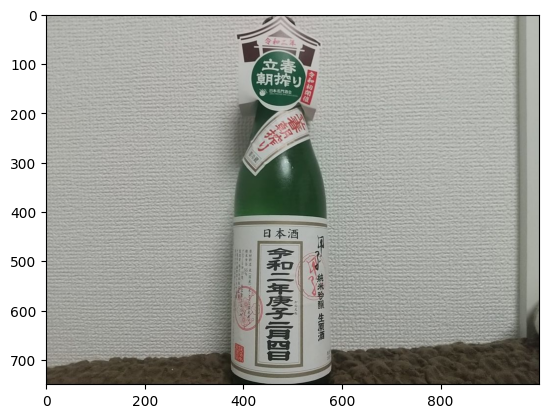

In [83]:
df = train_df.merge(train_cluster_df, left_index=True, right_on='gid').sort_values(by='cluster').query('cluster != -1')
img = plt.imread(df.iloc[-9]['filepath'])
plt.imshow(img)

In [82]:
df.tail(11)

,filename,brand_id,meigara,brand_id_label,meigara_label,filepath,gid,cluster
32286,200053600.jpg,260,甲子,179,1619,/work/data/query_images/200053600.jpg,200053600,3041
30487,200044326.jpg,3817,嘉美心,2501,789,/work/data/query_images/200044326.jpg,200044326,3041
35018,200067798.jpg,260,甲子,179,1619,/work/data/query_images/200067798.jpg,200067798,3041
38374,200084578.jpg,260,甲子,179,1619,/work/data/query_images/200084578.jpg,200084578,3041
26899,200026558.jpg,260,甲子,179,1619,/work/data/query_images/200026558.jpg,200026558,3041
32581,200055183.jpg,1140,田光,748,1612,/work/data/query_images/200055183.jpg,200055183,3055
30234,200043051.jpg,115,黎明,74,2463,/work/data/query_images/200043051.jpg,200043051,3055
29351,200038514.jpg,2203,立山,1443,1805,/work/data/query_images/200038514.jpg,200038514,3055
31939,200051975.jpg,1023,文佳人,674,1200,/work/data/query_images/200051975.jpg,200051975,3055
35086,200068133.jpg,2909,五郎八,1903,448,/work/data/query_images/200068133.jpg,200068133,3055


In [87]:
np.unique(cite_cluster_df['cluster'], return_counts=True)

(array([  -1, 3030, 3042, ..., 5290, 5291, 5292]),
 array([20828,   269,   103, ...,    11,    74,    15]))

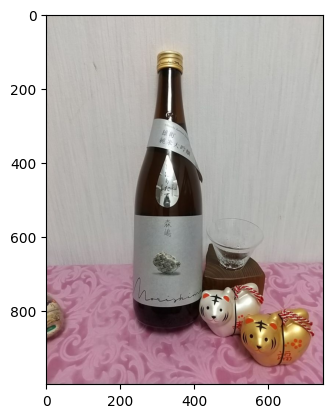

In [107]:
df = cite_df.merge(cite_cluster_df, left_on='gid', right_on='gid').sort_values(by='cluster').query('cluster != -1')
img = plt.imread(df.iloc[5]['filepath'])
plt.imshow(img)

In [101]:
set(oof_clusters) & set(cite_clusters)

{-1}

In [109]:
np.unique(test_clusters, return_counts=True)

(array([  -1, 3030, 3042, 3043, 3044, 3046, 3047, 3048, 3049, 3050, 3051,
        3052, 3053, 3054, 3058, 3059, 3060, 3061, 3062, 3063, 3066, 3068,
        3069, 3070, 3071, 3072, 3073, 3074, 3077, 3080, 3081, 3082, 3085,
        3086, 3088, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3098, 3099,
        3100, 3101, 3102, 3104, 3105, 3106, 3107, 3109, 3110, 3112, 3114,
        3115, 3116, 3117, 3118, 3119, 3121, 3122, 3123, 3124, 3127, 3128,
        3132, 3133, 3134, 3135, 3136, 3139, 3141, 3142, 3143, 3144, 3148,
        3150, 3154, 3155, 3156, 3158, 3159, 3163, 3165, 3166, 3168, 3169,
        3170, 3171, 3172, 3173, 3174, 3176, 3178, 3181, 3182, 3183, 3186,
        3188, 3189, 3192, 3195, 3197, 3201, 3202, 3203, 3209, 3211, 3213,
        3214, 3215, 3222, 3224, 3225, 3226, 3229, 3231, 3232, 3233, 3235,
        3237, 3238, 3239, 3241, 3242, 3243, 3244, 3245, 3246, 3248, 3249,
        3252, 3253, 3254, 3255, 3260, 3262, 3264, 3265, 3266, 3267, 3269,
        3279, 3283, 3285, 3287, 3290, 